Simulation Studies
----------
Author: Albert Ulmer  
Date: 2022-05-04 - 2022-06-30

In [14]:
# autoreload packages
%load_ext autoreload
%autoreload 2

# own function libraries
import config
import data
import plot
import extract

# import data & plotting libraries
import numpy as np
import pandas as pd
import datetime as dt
import time
import pulp
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import sqlite3

# import models
import mod_pred
import mod_direct
import mod_rule
import mod_stoch

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [15]:
### Set global flag whether to save plots to files or not
writefiles = 1

if writefiles:
    print("Writing output files!")
else:
    print("Leaving files alone!")


Writing output files!


In [16]:
### Set global flag whether to print debug messages while running code
showdebug = 1

if showdebug:
    print("Showing debug messages!")
else:
    print("No debug messages will be shown!")

Showing debug messages!


In [17]:
# connect to SQLite database
try:
    conn = sqlite3.connect('./database/dsmdata-sim.sqlite3')
    print('Connected to database...')
except:
    print('Database error!')
    exit()

Connected to database...


In [18]:
### load config
c1 = config.varpvbess_1()
c1


{'T': 24,
 'M_DT': 1,
 'M_LA': 24,
 'P_NE_MAX': 35,
 'P_NE_MIN': 0,
 'E_EL_CAP': 40,
 'E_EL_MAX': 39.6,
 'E_EL_MIN': 0.4,
 'E_EL_BEG': 20.0,
 'E_EL_END': 20.0,
 'P_EL_MAX': 12.78,
 'P_EL_MIN': 1,
 'P_EL_ETA': 0.95,
 'D_EL': 0.04,
 'S_EL': 0.9986666666666667,
 'E_EV_CAP': 40,
 'E_EV_MAX': 38.0,
 'E_EV_MIN': 2.0,
 'E_EV_BEG': 20.0,
 'P_EV_MAX': 22.08,
 'P_EV_MIN': 4.14,
 'P_EV_ETA': 0.85,
 'D_EV': 0.05,
 'S_EV': 0.9983333333333333,
 'P_PV_CAP': 40,
 'P_PV_ETA': 0.8}

# Load DSMData


## PV production data

In [19]:
pv_data = data.load_pv_data(freq=int(60*c1['M_DT']))
pv_data.PV_kW = pv_data.PV_kW/max(pv_data.PV_kW)*c1["P_PV_CAP"]*c1["P_PV_ETA"] # scale profile to fit configuration
if showdebug: print(pv_data)

                     PV_kW
2016-01-01 00:00:00    0.0
2016-01-01 01:00:00    0.0
2016-01-01 02:00:00    0.0
2016-01-01 03:00:00    0.0
2016-01-01 04:00:00    0.0
...                    ...
2016-12-31 19:00:00    0.0
2016-12-31 20:00:00    0.0
2016-12-31 21:00:00    0.0
2016-12-31 22:00:00    0.0
2016-12-31 23:00:00    0.0

[8784 rows x 1 columns]


## Electric vehicle data

In [20]:
ev_data = data.load_ev_data(num_vehicles=8, freq=int(60*c1['M_DT']))
if showdebug: print(ev_data)

                             driving  power  loadable
vehicle timestamp                                    
BL01    2016-01-01 00:00:00        0    0.0         1
        2016-01-01 01:00:00        0    0.0         1
        2016-01-01 02:00:00        0    0.0         1
        2016-01-01 03:00:00        0    0.0         1
        2016-01-01 04:00:00        0    0.0         1
...                              ...    ...       ...
CC01    2016-12-31 19:00:00        0    0.0         1
        2016-12-31 20:00:00        0    0.0         1
        2016-12-31 21:00:00        0    0.0         1
        2016-12-31 22:00:00        0    0.0         1
        2016-12-31 23:00:00        0    0.0         1

[70272 rows x 3 columns]


# Simulation


In [21]:
# Dictionary for storing target value results
n_out_ceil = dict()
sol_time = dict()

In [22]:
# define percentage steps for variable PV sizing
pv_percentages = np.linspace(1, 0, 5).round(2)
if showdebug: print(pv_percentages)

[1.   0.75 0.5  0.25 0.  ]


In [23]:
# define percentage steps for variable BESS sizing
bess_percentages = np.linspace(1, 0, 5).round(2)
if showdebug: print(bess_percentages)

[1.   0.75 0.5  0.25 0.  ]


In [24]:
# define optimization models
opt_models = ['direct', 'rule', 'pred', 'stoch', 'perfect']
if showdebug: print(opt_models)

['direct', 'rule', 'pred', 'stoch', 'perfect']


In [25]:
### loop through PV, BESS and optimization models

# fetch basic configuration
c0 = config.varpvbess_1()

# define day for simulation
start = pd.Timestamp('2016-06-22 00:00:40.188679')
start = start.round(str(int(60*c0['M_DT']))+'T')
if showdebug: print(start)

# define periods according to configuration
periods = np.arange(0, c0["T"])
if showdebug: print(periods)

# log last run to separate database table for easier analysis
lastrun = pd.DataFrame()
lastrun.loc[0, "timestamp"] = pd.to_datetime(dt.datetime.now())
lastrun.to_sql(name="lastrun", con=conn, if_exists="append")

2016-06-22 00:00:00
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]


1

In [26]:
# loop through entire simulation space
for my_pvprc in pv_percentages:
    
    # fetch fresh configuration
    c1 = config.varpvbess_1(pvprc=my_pvprc)
    
    # reload original PV production data and rescale to desired capacity
    pv_data = data.load_pv_data(freq=int(60*c1['M_DT']))
    pv_data.PV_kW = pv_data.PV_kW/max(pv_data.PV_kW)*c1["P_PV_CAP"]*c1["P_PV_ETA"] 

    for my_bessprc in bess_percentages:
    
        for my_model in opt_models:
        
            # fetch fresh configuration
            c1 = config.varpvbess_1(pvprc=my_pvprc, bessprc=my_bessprc)
            
            # initialize timing
            lookahead = c1["M_LA"]
            lookback = lookahead * 8  # look back 8 times the lookahead 
            
            # initialize SOCs with the config defaults for the first run
            batterystate_local = c1['E_EL_BEG']
            batterystate_ev = dict()
            my_vehicles = list(ev_data.index.get_level_values('vehicle').unique())
            for i, v in enumerate(my_vehicles):
                batterystate_ev[v] = c1['E_EV_BEG']
                #batterystate_ev[v] = .25*c1['E_EV_CAP'] + (.75*c1['E_EV_CAP']-.25*c1['E_EV_CAP'])/len(my_vehicles)*i

                        
            for my_period in periods:
                
                # initialize metadata                
                my_runningdate = str(dt.datetime.now())
                #my_now = start + pd.Timedelta(my_period*int(60*c1['M_DT']), 'T')
                my_label = f"{my_model}_pv{my_pvprc:.2f}_bess{my_bessprc:.2f}_period{my_period:02d}"

                # instantiate solver (CBC or Gurobi)
                solver = pulp.PULP_CBC_CMD(
                    gapRel=.01, gapAbs=.1, timeLimit=1800, logPath=f"logs/{my_label}.log", msg=False, presolve=True)
                # solver = pulp.GUROBI_CMD(
                #     gapRel=.01, gapAbs=.1, timeLimit=600, logPath=f"logs/{my_label}.log", msg=False)
                
                ##################################################
                ### Predictive 
                ##################################################
                if my_model == "pred":
    
                    # calculate current iteration timestamp
                    my_now = start + pd.Timedelta(my_period*int(60*c1['M_DT']), 'T')

                    # calculate current iteration timebracket for history data
                    my_past_from = my_now - pd.Timedelta(lookback*int(60*c1['M_DT']), 'T')
                    my_past_to = my_now - pd.Timedelta(1*int(60*c1['M_DT']), 'T')

                    # get current pv data
                    my_current_pv = data.get_current_pv_data(pv_data, my_now)
                    # get current ev data
                    my_current_ev = data.get_current_ev_data(ev_data, my_now)

                    # get past pv data    
                    my_history_pv = data.get_history_pv_data(pv_data, my_past_from, my_past_to)
                    # get past ev data    
                    my_history_ev = data.get_history_ev_data(ev_data, my_past_from, my_past_to)
                        
                    # predict future pv data    
                    my_predicted_pv = data.predict_pv_data(my_history_pv, lookahead)
                    # predict future ev data    
                    my_predicted_ev = data.predict_ev_data(my_history_ev, lookahead)

                    # combine current and predicted pv data
                    my_model_pv = data.get_model_pv_data(my_current_pv, my_predicted_pv)
                    # combine current and predicted ev data
                    my_model_ev = data.get_model_ev_data(my_current_ev, my_predicted_ev)

                    # add column to EV data as EVSOC column
                    for v in my_vehicles:
                        my_model_ev.loc[(v, 0), 'EVSOC'] = batterystate_ev[v]

                    # set current battery SOC to value from last iteration
                    c1['E_EL_BEG'] = batterystate_local

                    # solve model
                    m1 = mod_pred.constructModel(c1, my_model_pv, my_model_ev)

                    tic = time.perf_counter()
                    result = m1.solve(solver)
                    toc = time.perf_counter()
                    runningtime = round(toc-tic, 3)
                    print('result: ', result)
                    

                    # extract all variables from model solution
                    result0_pred, result1_pred, result2_pred, _ = extract.extractVariablesDataframe(model=m1, label=my_label, runningdate=my_runningdate)
                    result2_pred.index.names = ['vehicle', 'period']

                    try:
                        fig = plot.plot_sys_timeseries_simple(
                            result0_pred, result1_pred, result2_pred, my_model_pv, my_model_ev)
                        if writefiles:
                            plt.savefig(f'images/{my_label}.jpg', bbox_inches="tight", dpi=200)
                            plt.close(fig)
                    except:
                        print("something went wrong!")

                    # add metadata for later analysis
                    result0_pred["runningtime"] = runningtime
                    result0_pred["pvprc"] = my_pvprc
                    result0_pred["bessprc"] = my_bessprc
                    result0_pred["model"] = my_model
                    my_model_pv["label"] = my_label
                    my_model_pv["runningdate"] = pd.to_datetime(my_runningdate)
                    my_model_ev["label"] = my_label
                    my_model_ev["runningdate"] = pd.to_datetime(my_runningdate)
                    
                    # save data to database
                    result0_pred.to_sql(name="result0_pred", con=conn, if_exists="append")
                    result1_pred.to_sql(name="result1_pred", con=conn, if_exists="append")
                    result2_pred.to_sql(name="result2_pred", con=conn, if_exists="append")
                    my_model_pv.to_sql(name="modelpv_pred", con=conn, if_exists="append")
                    my_model_ev.to_sql(name="modelev_pred", con=conn, if_exists="append")
                    
                    
                    # print some debugging info...
                    print('Period: ', my_period, 'n_out: ', result1_pred.GridDraw[0])

                    # set battery SOCs for next iteration, enforce non-negativity
                    batterystate_local = max(result1_pred.BatterySOC.loc[1], c1["E_EL_MIN"])
                    batterystate_ev = np.maximum(
                        result2_pred.EVSOC.xs(1, level='period'), c1["E_EV_MIN"]).to_dict()

                    # end of for loop
                    
                ##################################################
                ### Perfect Information
                ##################################################
                if my_model == "perfect":     
                    
                    # calculate current iteration timestamp
                    my_now = start + \
                        pd.Timedelta(my_period*int(60*c1['M_DT']), 'T')

                    # calculate current iteration timebracket for current-day data
                    my_from = my_now 
                    my_to = my_now + \
                        pd.Timedelta(lookahead*int(60*c1['M_DT']), 'T') - \
                        pd.Timedelta(1*int(60*c1['M_DT']), 'T')

                    # get current pv data
                    my_current_pv = data.get_current_pv_data(pv_data, my_now)
                    # get current ev data
                    my_current_ev = data.get_current_ev_data(ev_data, my_now)

                    # get future pv data    
                    my_perfect_pv = data.get_history_pv_data(pv_data, my_from, my_to)
                    
                    # get future ev data    
                    my_perfect_ev = data.get_history_ev_data(ev_data, my_from, my_to)

                    # combine current and predicted pv data
                    my_model_pv = data.get_model_pv_data(my_current_pv, data.predict_pv_data(my_perfect_pv, lookahead))

                    # combine current and predicted ev data
                    my_model_ev = data.get_model_ev_data(my_current_ev, data.predict_ev_data(my_perfect_ev, lookahead))

                    # add column to EV data as EVSOC column
                    for v in my_vehicles:
                        my_model_ev.loc[(v, 0), 'EVSOC'] = batterystate_ev[v]

                    # set current battery SOC to value from last iteration
                    c1['E_EL_BEG'] = batterystate_local

                    # solve model
                    m1 = mod_pred.constructModel(c1, my_model_pv, my_model_ev)

                    tic = time.perf_counter()
                    result = m1.solve(solver)
                    toc = time.perf_counter()
                    runningtime = round(toc-tic, 3)
                    print('result: ', result)

                    # extract all variables from model solution
                    result0_perfect, result1_perfect, result2_perfect, _ = extract.extractVariablesDataframe(
                        model=m1, label=my_label, runningdate=my_runningdate)
                    result2_perfect.index.names = ['vehicle', 'period']

                    try:
                        fig = plot.plot_sys_timeseries_simple(
                            result0_perfect, result1_perfect, result2_perfect, my_model_pv, my_model_ev)
                        if writefiles:
                            plt.savefig(
                                f'images/{my_label}.jpg', bbox_inches="tight", dpi=200)
                            plt.close(fig)
                    except:
                        print("something went wrong!")

                    # add metadata for later analysis
                    result0_perfect["runningtime"] = runningtime
                    result0_perfect["pvprc"] = my_pvprc
                    result0_perfect["bessprc"] = my_bessprc
                    result0_perfect["model"] = my_model
                    my_model_pv["label"] = my_label
                    my_model_pv["runningdate"] = pd.to_datetime(my_runningdate)
                    my_model_ev["label"] = my_label
                    my_model_ev["runningdate"] = pd.to_datetime(my_runningdate)

                    # save data to database
                    result0_perfect.to_sql(name="result0_perfect",
                                        con=conn, if_exists="append")
                    result1_perfect.to_sql(name="result1_perfect",
                                        con=conn, if_exists="append")
                    result2_perfect.to_sql(name="result2_perfect",
                                        con=conn, if_exists="append")
                    my_model_pv.to_sql(name="modelpv_perfect",
                                       con=conn, if_exists="append")
                    my_model_ev.to_sql(name="modelev_perfect",
                                       con=conn, if_exists="append")

                    # print some debugging info...
                    print('Period: ', my_period, 'n_out: ',
                          result1_perfect.GridDraw[0])

                    # set battery SOCs for next iteration, enforce non-negativity
                    batterystate_local = max(
                        result1_perfect.BatterySOC.loc[1], c1["E_EL_MIN"])
                    batterystate_ev = np.maximum(
                        result2_perfect.EVSOC.xs(1, level='period'), c1["E_EV_MIN"]).to_dict()


                ##################################################
                ### Direct Charging
                ##################################################
                if my_model == "direct":     
                    # calculate current iteration timestamp
                    my_now = start + \
                        pd.Timedelta(my_period*int(60*c1['M_DT']), 'T')

                    # calculate current iteration timebracket for history data
                    my_past_from = my_now - \
                        pd.Timedelta(lookback*int(60*c1['M_DT']), 'T')
                    my_past_to = my_now - \
                        pd.Timedelta(1*int(60*c1['M_DT']), 'T')

                    # get current pv data
                    my_current_pv = data.get_current_pv_data(pv_data, my_now)
                    # get current ev data
                    my_current_ev = data.get_current_ev_data(ev_data, my_now)

                    # get past pv data
                    my_history_pv = data.get_history_pv_data(
                        pv_data, my_past_from, my_past_to)
                    # get past ev data
                    my_history_ev = data.get_history_ev_data(
                        ev_data, my_past_from, my_past_to)

                    # predict future pv data
                    my_predicted_pv = data.predict_pv_data(
                        my_history_pv, lookahead)
                    # predict future ev data
                    my_predicted_ev = data.predict_ev_data(
                        my_history_ev, lookahead)

                    # combine current and predicted pv data
                    my_model_pv = data.get_model_pv_data(
                        my_current_pv, my_predicted_pv)
                    # combine current and predicted ev data
                    my_model_ev = data.get_model_ev_data(
                        my_current_ev, my_predicted_ev)

                    # add column to EV data as EVSOC column
                    for v in my_vehicles:
                        my_model_ev.loc[(v, 0), 'EVSOC'] = batterystate_ev[v]

                    # set current battery SOC to value from last iteration
                    c1['E_EL_BEG'] = batterystate_local

                    # solve model
                    m1 = mod_direct.constructModel(c1, my_model_pv, my_model_ev)

                    tic = time.perf_counter()
                    result = m1.solve(solver)
                    toc = time.perf_counter()
                    runningtime = round(toc-tic, 3)
                    print('result: ', result)

                    # extract all variables from model solution
                    result0_direct, result1_direct, result2_direct, _ = extract.extractVariablesDataframe(
                        model=m1, label=my_label, runningdate=my_runningdate)
                    result2_direct.index.names = ['vehicle', 'period']

                    try:
                        fig = plot.plot_sys_timeseries_simple(
                            result0_direct, result1_direct, result2_direct, my_model_pv, my_model_ev)
                        if writefiles:
                            plt.savefig(
                                f'images/{my_label}.jpg', bbox_inches="tight", dpi=200)
                            plt.close(fig)
                    except:
                        print("something went wrong!")

                    # add metadata for later analysis
                    result0_direct["runningtime"] = runningtime
                    result0_direct["pvprc"] = my_pvprc
                    result0_direct["bessprc"] = my_bessprc
                    result0_direct["model"] = my_model
                    my_model_pv["label"] = my_label
                    my_model_pv["runningdate"] = pd.to_datetime(my_runningdate)
                    my_model_ev["label"] = my_label
                    my_model_ev["runningdate"] = pd.to_datetime(my_runningdate)

                    # save data to database
                    result0_direct.to_sql(name="result0_direct",
                                        con=conn, if_exists="append")
                    result1_direct.to_sql(name="result1_direct",
                                        con=conn, if_exists="append")
                    result2_direct.to_sql(name="result2_direct",
                                        con=conn, if_exists="append")
                    my_model_pv.to_sql(name="modelpv_direct",
                                       con=conn, if_exists="append")
                    my_model_ev.to_sql(name="modelev_direct",
                                       con=conn, if_exists="append")

                    # print some debugging info...
                    print('Period: ', my_period, 'n_out: ', result1_direct.GridDraw[0])

                    # set battery SOCs for next iteration, enforce non-negativity
                    batterystate_local = max(
                        result1_direct.BatterySOC.loc[1], c1["E_EL_MIN"])
                    batterystate_ev = np.maximum(
                        result2_direct.EVSOC.xs(1, level='period'), c1["E_EV_MIN"]).to_dict()


                ##################################################
                ### Rule-based Charging
                ##################################################
                if my_model == "rule":
                    # calculate current iteration timestamp
                    my_now = start + \
                        pd.Timedelta(my_period*int(60*c1['M_DT']), 'T')

                    # calculate current iteration timebracket for history data
                    my_past_from = my_now - \
                        pd.Timedelta(lookback*int(60*c1['M_DT']), 'T')
                    my_past_to = my_now - \
                        pd.Timedelta(1*int(60*c1['M_DT']), 'T')

                    # get current pv data
                    my_current_pv = data.get_current_pv_data(pv_data, my_now)
                    # get current ev data
                    my_current_ev = data.get_current_ev_data(ev_data, my_now)

                    # get past pv data
                    my_history_pv = data.get_history_pv_data(
                        pv_data, my_past_from, my_past_to)
                    # get past ev data
                    my_history_ev = data.get_history_ev_data(
                        ev_data, my_past_from, my_past_to)

                    # predict future pv data
                    my_predicted_pv = data.predict_pv_data(
                        my_history_pv, lookahead)
                    # predict future ev data
                    my_predicted_ev = data.predict_ev_data(
                        my_history_ev, lookahead)

                    # combine current and predicted pv data
                    my_model_pv = data.get_model_pv_data(
                        my_current_pv, my_predicted_pv)
                    # combine current and predicted ev data
                    my_model_ev = data.get_model_ev_data(
                        my_current_ev, my_predicted_ev)

                    # add column to EV data as EVSOC column
                    for v in my_vehicles:
                        my_model_ev.loc[(v, 0), 'EVSOC'] = batterystate_ev[v]

                    # set current battery SOC to value from last iteration
                    c1['E_EL_BEG'] = batterystate_local

                    # solve model
                    m1 = mod_rule.constructModel(
                        c1, my_model_pv, my_model_ev)

                    tic = time.perf_counter()
                    result = m1.solve(solver)
                    toc = time.perf_counter()
                    runningtime = round(toc-tic, 3)
                    print('result: ', result)

                    # extract all variables from model solution
                    result0_rule, result1_rule, result2_rule, _ = extract.extractVariablesDataframe(
                        model=m1, label=my_label, runningdate=my_runningdate)
                    result2_rule.index.names = ['vehicle', 'period']

                    try:
                        fig = plot.plot_sys_timeseries_simple(
                            result0_rule, result1_rule, result2_rule, my_model_pv, my_model_ev)
                        if writefiles:
                            plt.savefig(
                                f'images/{my_label}.jpg', bbox_inches="tight", dpi=200)
                            plt.close(fig)
                    except:
                        print("something went wrong!")

                    # add metadata for later analysis
                    result0_rule["runningtime"] = runningtime
                    result0_rule["pvprc"] = my_pvprc
                    result0_rule["bessprc"] = my_bessprc
                    result0_rule["model"] = my_model
                    my_model_pv["label"] = my_label
                    my_model_pv["runningdate"] = pd.to_datetime(my_runningdate)
                    my_model_ev["label"] = my_label
                    my_model_ev["runningdate"] = pd.to_datetime(my_runningdate)

                    # save data to database
                    result0_rule.to_sql(name="result0_rule",
                                          con=conn, if_exists="append")
                    result1_rule.to_sql(name="result1_rule",
                                          con=conn, if_exists="append")
                    result2_rule.to_sql(name="result2_rule",
                                          con=conn, if_exists="append")
                    my_model_pv.to_sql(name="modelpv_rule",
                                       con=conn, if_exists="append")
                    my_model_ev.to_sql(name="modelev_rule",
                                       con=conn, if_exists="append")

                    # print some debugging info...
                    print('Period: ', my_period, 'n_out: ',
                          result1_rule.GridDraw[0])

                    # set battery SOCs for next iteration, enforce non-negativity
                    batterystate_local = max(
                        result1_rule.BatterySOC.loc[1], c1["E_EL_MIN"])
                    batterystate_ev = np.maximum(
                        result2_rule.EVSOC.xs(1, level='period'), c1["E_EV_MIN"]).to_dict()


                ##################################################
                ### Stochastic Charging
                ##################################################
                if my_model == "stoch":
                    # calculate current iteration timestamp
                    my_now = start + \
                        pd.Timedelta(my_period*int(60*c1['M_DT']), 'T')

                    # calculate current iteration timebracket for history data
                    my_past_from = my_now - \
                        pd.Timedelta(lookback*int(60*c1['M_DT']), 'T')
                    my_past_to = my_now - \
                        pd.Timedelta(1*int(60*c1['M_DT']), 'T')

                    # get current pv data
                    my_current_pv = data.get_current_pv_data(pv_data, my_now)
                    # get current ev data
                    my_current_ev = data.get_current_ev_data(ev_data, my_now)

                    # get past pv data
                    my_history_pv = data.get_history_pv_data(
                        pv_data, my_past_from, my_past_to)
                    # get past ev data
                    my_history_ev = data.get_history_ev_data(
                        ev_data, my_past_from, my_past_to)

                    # predict future pv data
                    my_predicted_pv = data.predict_pv_data(
                        my_history_pv, lookahead)
                    # get ev scenarios
                    my_scenarios_ev = data.scenarios_ev_data(my_history_ev, lookahead)

                    # combine current and predicted pv data
                    my_model_pv = data.get_model_pv_data(
                        my_current_pv, my_predicted_pv)
                    # combine current and ev scenarios data
                    my_model_ev = data.get_model_ev_scenarios(my_current_ev, my_scenarios_ev)   

                    # add column to EV data as EVSOC column
                    for v in my_vehicles:
                        for s in my_model_ev.index.get_level_values('scenario').unique():
                            my_model_ev.loc[(v, 0, s), 'EVSOC'] = batterystate_ev[v]

                    # set current battery SOC to value from last iteration
                    c1['E_EL_BEG'] = batterystate_local

                    # solve model
                    m1 = mod_stoch.constructModel(
                        c1, my_model_pv, my_model_ev)

                    tic = time.perf_counter()
                    result = m1.solve(solver)
                    toc = time.perf_counter()
                    runningtime = round(toc-tic, 3)
                    print('result: ', result)

                    # extract all variables from model solution
                    result0_stoch, result1_stoch, result2_stoch, result3_stoch = extract.extractVariablesDataframe(
                        model=m1, label=my_label, runningdate=my_runningdate)
                    result2_stoch.index.names = ['period', 'scenario']
                    result3_stoch.index.names = ['vehicle', 'period', 'scenario']

                    try:
                        fig = plot.plot_sys_timeseries_stochastic(
                            result0_stoch, result1_stoch, result2_stoch, result3_stoch, my_model_pv, my_model_ev)
                        if writefiles:
                            plt.savefig(
                                f'images/{my_label}.jpg', bbox_inches="tight", dpi=200)
                            plt.close(fig)
                    except:
                        print("something went wrong!")

                    # add metadata for later analysis
                    result0_stoch["runningtime"] = runningtime
                    result0_stoch["pvprc"] = my_pvprc
                    result0_stoch["bessprc"] = my_bessprc
                    result0_stoch["model"] = my_model
                    my_model_pv["label"] = my_label
                    my_model_pv["runningdate"] = pd.to_datetime(my_runningdate)
                    my_model_ev["label"] = my_label
                    my_model_ev["runningdate"] = pd.to_datetime(my_runningdate)

                    # save data to database
                    result0_stoch.to_sql(name="result0_stoch",
                                          con=conn, if_exists="append")
                    result1_stoch.to_sql(name="result1_stoch",
                                          con=conn, if_exists="append")
                    result2_stoch.to_sql(name="result2_stoch",
                                          con=conn, if_exists="append")
                    result3_stoch.to_sql(name="result3_stoch",
                                          con=conn, if_exists="append")
                    my_model_pv.to_sql(name="modelpv_stoch",
                                       con=conn, if_exists="append")
                    my_model_ev.to_sql(name="modelev_stoch",
                                       con=conn, if_exists="append")

                    # print some debugging info...
                    print('Period: ', my_period, 'n_out: ', result2_stoch.GridDraw[0, 0])

                    # set battery SOCs for next iteration, enforce non-negativity
                    #if result == 1:
                    batterystate_local = max(result2_stoch.BatterySOC.loc[1,0], c1["E_EL_MIN"])
                    batterystate_ev = np.maximum(result3_stoch.EVSOC.loc[pd.IndexSlice[:, 1, 0]].copy(), c1["E_EV_MIN"]).to_dict()









                # end of for periods-loop


                print("worked on: ", my_pvprc, my_bessprc, my_model, my_period,
                      my_now, my_runningdate, f"{toc-tic:0.3f}")

                #end of model if




                ######end of period loop
            ######end of model loop
        ######end of bessprc loop
    ######end of pvprc loop

####### finalize





result:  1
Period:  0 n_out:  35.0
worked on:  1.0 1.0 direct 0 2016-06-22 00:00:00 2022-06-09 08:56:34.320867 1.544
result:  1
Period:  1 n_out:  35.0
worked on:  1.0 1.0 direct 1 2016-06-22 01:00:00 2022-06-09 08:56:38.203533 1.134
result:  1
Period:  2 n_out:  35.0
worked on:  1.0 1.0 direct 2 2016-06-22 02:00:00 2022-06-09 08:56:41.909953 0.857
result:  1
Period:  3 n_out:  19.439748
worked on:  1.0 1.0 direct 3 2016-06-22 03:00:00 2022-06-09 08:56:44.709559 0.824
result:  1
Period:  4 n_out:  4.2804826
worked on:  1.0 1.0 direct 4 2016-06-22 04:00:00 2022-06-09 08:56:47.528695 0.381
result:  1
Period:  5 n_out:  4.2697291
worked on:  1.0 1.0 direct 5 2016-06-22 05:00:00 2022-06-09 08:56:50.281618 0.640
result:  1
something went wrong!
Period:  6 n_out:  0.0
worked on:  1.0 1.0 direct 6 2016-06-22 06:00:00 2022-06-09 08:56:53.359582 0.545
result:  -1
Period:  7 n_out:  12.529111
worked on:  1.0 1.0 direct 7 2016-06-22 07:00:00 2022-06-09 08:56:54.443793 0.205
result:  -1
Period:  8

AttributeError: module 'plot' has no attribute 'recplot'

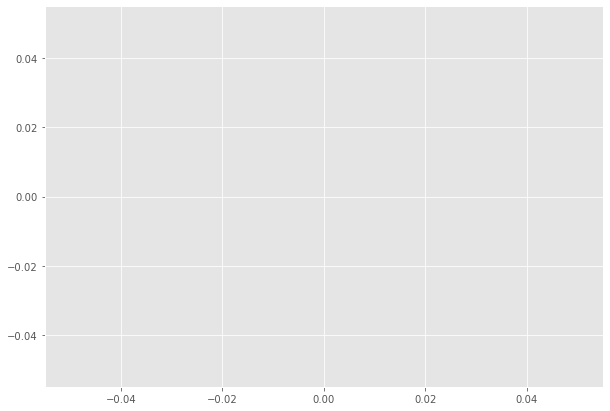

In [27]:
# rules
fig, ax = plt.subplots(figsize=(10, 7))

# Plotten
ax.plot()
plot.recplot(ax,   0,  0,   1,   1, 'white',       '', '')
plot.recplot(ax,   0,  0,   .2,  1, 'pink', '1', '/')
plot.recplot(ax,  .2,  0,   .2, .75, 'orange',  '2', '\\')
plot.recplot(ax,  .4,  0,   .2,  .5, 'magenta', '3', '/')
plot.recplot(ax,  .6,  0,   .2,  .25, 'lightgreen', '4', '\\')
plot.recplot(ax,  .8,  0,   .2,  0, 'lightblue', '5', '/')
plt.xlabel('$\\frac{Ladestand}{E_{max}}$')
plt.ylabel('$0=P_{min}, 1=P_{max}$')
plt.title('Ladeleistungsbegrenzung SoC->kW')
